## Approach

1. Identify available dates and temporal frequency of observations for a given collection using the GHGC API `/stac` endpoint. The collection processed in this notebook is the Land-Atmosphere Carbon Flux data product.
2. Pass the STAC item into the raster API `/stac/tilejson.json `endpoint.
3. Using `folium.plugins.DualMap`, visualize two tiles (side-by-side), allowing time point comparison.
4. After the visualization, perform zonal statistics for a given polygon.
   

## About the Data

This dataset presents a variety of carbon flux parameters derived from the Más Informada Carnegie-Ames-Stanford-Approach (MiCASA) model. The model’s input data includes air temperature, precipitation, incident solar radiation, a soil classification map, and several satellite derived products. All model calculations are driven by analyzed meteorological data from NASA’s Modern-Era Retrospective analysis for Research and Application, Version 2 (MERRA-2). The resulting product provides global, daily data at 0.1 degree resolution from January 2001 through December 2023. It includes carbon flux variables expressed in units of kilograms of carbon per square meter per day (kg Carbon/m²/day) from net primary production (NPP), heterotrophic respiration (Rh), wildfire emissions (FIRE), fuel wood burning emissions (FUEL), net ecosystem exchange (NEE), and net biosphere exchange (NBE). The latter two are derived from the first four (see Scientific Details below). MiCASA is an extensive revision of the CASA – Global Fire Emissions Database, version 3 (CASA-GFED3) product. CASA-GFED3 and earlier versions of MERRA-driven CASA-GFED carbon fluxes have been used in several atmospheric carbon dioxide (CO₂) transport studies, serve as a community standard for priors of flux inversion systems, and through the support of NASA’s Carbon Monitoring System (CMS), help characterize, quantify, understand and predict the evolution of global carbon sources and sinks.

# Installing the Required Libraries
Required libraries are pre-installed on the GHG Center Hub. If you need to run this notebook elsewhere, please install them with this line in a code cell:

%pip install requests, folium, rasterstats, pystac_client, pandas, matplotlib

## Querying the STAC API
Please run the next cell to import the required libraries. 

In [51]:
import requests
import folium
import folium.plugins
from folium import Map, TileLayer 
from pystac_client import Client 
import branca 
import pandas as pd
import matplotlib.pyplot as plt

In [52]:
# Provide STAC and RASTER API endpoints
STAC_API_URL = "http://dev.ghg.center/ghgcenter/api/stac"
RASTER_API_URL = "https://dev.ghg.center/ghgcenter/api/raster"

# Please use the collection name similar to the one used in the STAC collection.
# Name of the collection for CASA GFED Land-Atmosphere Carbon Flux monthly emissions. 
collection_name = "micasa-carbonflux-daygrid-v1"
# rh = Heterotrophic Respiration
asset_name = "rh"

In [53]:
# Fetch the collection from STAC collections using the appropriate endpoint
# the 'requests' library allows a HTTP request possible
collection = requests.get(f"{STAC_API_URL}/collections/{collection_name}").json()
collection

{'id': 'micasa-carbonflux-daygrid-v1',
 'type': 'Collection',
 'links': [{'rel': 'items',
   'type': 'application/geo+json',
   'href': 'https://dev.ghg.center/ghgcenter/api/stac/collections/micasa-carbonflux-daygrid-v1/items'},
  {'rel': 'parent',
   'type': 'application/json',
   'href': 'https://dev.ghg.center/ghgcenter/api/stac/'},
  {'rel': 'root',
   'type': 'application/json',
   'href': 'https://dev.ghg.center/ghgcenter/api/stac/'},
  {'rel': 'self',
   'type': 'application/json',
   'href': 'https://dev.ghg.center/ghgcenter/api/stac/collections/micasa-carbonflux-daygrid-v1'}],
 'title': 'MiCASA Land Carbon Flux v1',
 'assets': None,
 'extent': {'spatial': {'bbox': [[-180, -90, 180, 90]]},
  'temporal': {'interval': [['2001-01-01T00:00:00+00:00',
     '2001-03-08T00:00:00+00:00']]}},
 'license': 'CC0 1.0',
 'keywords': None,
 'providers': [{'url': None,
   'name': 'NASA',
   'roles': None,
   'description': None}],
 'summaries': {'datetime': ['2001-01-01T00:00:00Z', '2001-03-08

Examining the contents of our `collection` under the `temporal` variable, we see that the data is available from January 2003 to December 2017. By looking at the `dashboard:time density`, we observe that the periodic frequency of these observations is monthly.

In [54]:
# Create a function that would search for the above data collection in the STAC API
def get_item_count(collection_id):
    count = 0
    items_url = f"{STAC_API_URL}/collections/{collection_id}/items"

    while True:
        response = requests.get(items_url)

        if not response.ok:
            print("error getting items")
            exit()

        stac = response.json()
        count += int(stac["context"].get("returned", 0))
        next = [link for link in stac["links"] if link["rel"] == "next"]

        if not next:
            break
        items_url = next[0]["href"]
        items_url = next[0]["href"]
        temp = items_url.split('/')
        temp.insert(3, 'ghgcenter')
        temp.insert(4, 'api')
        temp.insert(5, 'stac')
        items_url = '/'.join(temp)

    return count

In [55]:
# Apply the above function and check the total number of items available within the collection
number_of_items = get_item_count(collection_name)
items = requests.get(f"{STAC_API_URL}/collections/{collection_name}/items?limit=600").json()["features"]
print(f"Found {len(items)} items")

Found 67 items


In [56]:
# Examine the first item in the collection
items[0]

{'id': 'micasa-carbonflux-daygrid-v1-20010308',
 'bbox': [-180.0, -90.0, 179.99999999999994, 90.0],
 'type': 'Feature',
 'links': [{'rel': 'collection',
   'type': 'application/json',
   'href': 'https://dev.ghg.center/ghgcenter/api/stac/collections/micasa-carbonflux-daygrid-v1'},
  {'rel': 'parent',
   'type': 'application/json',
   'href': 'https://dev.ghg.center/ghgcenter/api/stac/collections/micasa-carbonflux-daygrid-v1'},
  {'rel': 'root',
   'type': 'application/json',
   'href': 'https://dev.ghg.center/ghgcenter/api/stac/'},
  {'rel': 'self',
   'type': 'application/geo+json',
   'href': 'https://dev.ghg.center/ghgcenter/api/stac/collections/micasa-carbonflux-daygrid-v1/items/micasa-carbonflux-daygrid-v1-20010308'}],
 'assets': {'rh': {'href': 's3://ghgc-data-store-dev/MiCASA/v1/daily/2001/03/MiCASAv1_flux_Rh_x3600_y1800_daily_20010308.tif',
   'type': 'image/tiff; application=geotiff; profile=cloud-optimized',
   'roles': ['data', 'layer'],
   'title': 'Heterotrophic respiratio

## Exploring Changes in Carbon Flux Levels Using the Raster API

We will explore changes in the land atmosphere Carbon flux `Heterotrophic Respiration` and examine their impacts over time. We'll then visualize the outputs on a map using `folium`. 

In [57]:
# To access the year value from each item more easily, this will let us query more explicitly by year and month (e.g., 2020-02)
items = {item["properties"]["datetime"][:10]: item for item in items} 

Below, we are entering the minimum and maximum values to provide our upper and lower bounds in `rescale_values`.

In [58]:
rescale_values = {"max":items[list(items.keys())[0]]["assets"][asset_name]["raster:bands"][0]["histogram"]["max"], "min":items[list(items.keys())[0]]["assets"][asset_name]["raster:bands"][0]["histogram"]["min"]}

Now, we will pass the item id, collection name, and `rescaling_factor` to the `Raster API` endpoint. We will do this twice, once for December 2003 and again for December 2017, so that we can visualize each event independently.

In [59]:
color_map = "purd" # please refer to matplotlib library if you'd prefer choosing a different color ramp.
# For more information on Colormaps in Matplotlib, please visit https://matplotlib.org/stable/users/explain/colors/colormaps.html

# To change the year and month of the observed parameter, you can modify the "items['YYYY-MM']" statement
# For example, you can change the current statement "items['2003-12']" to "items['2016-10']" 
date1 = '2001-01-01'
date1_tile = requests.get(
    f"{RASTER_API_URL}/stac/tilejson.json?collection={items[date1]['collection']}&item={items[date1]['id']}"
    f"&assets={asset_name}"
    f"&color_formula=gamma+r+1.05&colormap_name={color_map}"
    f"&rescale={rescale_values['min']},{rescale_values['max']}", 
).json()
date1_tile

{'tilejson': '2.2.0',
 'version': '1.0.0',
 'scheme': 'xyz',
 'tiles': ['https://dev.ghg.center/ghgcenter/api/raster/stac/tiles/WebMercatorQuad/{z}/{x}/{y}@1x?collection=micasa-carbonflux-daygrid-v1&item=micasa-carbonflux-daygrid-v1-20010101&assets=rh&color_formula=gamma+r+1.05&colormap_name=purd&rescale=-0.28565365076065063%2C5.658170223236084'],
 'minzoom': 0,
 'maxzoom': 24,
 'bounds': [-180.0, -90.0, 179.99999999999994, 90.0],
 'center': [-2.842170943040401e-14, 0.0, 0]}

In [60]:
# Now we apply the same process used in the previous step for the December 2017 tile
date2 = '2001-01-30'
date2_tile = requests.get(
    f"{RASTER_API_URL}/stac/tilejson.json?collection={items[date1]['collection']}&item={items[date1]['id']}"
    f"&assets={asset_name}"
    f"&color_formula=gamma+r+1.05&colormap_name={color_map}"
    f"&rescale={rescale_values['min']},{rescale_values['max']}", 
).json()
date2_tile

{'tilejson': '2.2.0',
 'version': '1.0.0',
 'scheme': 'xyz',
 'tiles': ['https://dev.ghg.center/ghgcenter/api/raster/stac/tiles/WebMercatorQuad/{z}/{x}/{y}@1x?collection=micasa-carbonflux-daygrid-v1&item=micasa-carbonflux-daygrid-v1-20010101&assets=rh&color_formula=gamma+r+1.05&colormap_name=purd&rescale=-0.28565365076065063%2C5.658170223236084'],
 'minzoom': 0,
 'maxzoom': 24,
 'bounds': [-180.0, -90.0, 179.99999999999994, 90.0],
 'center': [-2.842170943040401e-14, 0.0, 0]}

## Visualizing Land-Atmosphere Carbon Flux (Heterotrophic Respiration)


In [61]:
# For this study we are going to compare the RH level in 2003 and 2017 over the State of Texas 
# To change the location, you can simply insert the latitude and longitude of the area of your interest in the "location=(LAT, LONG)" statement
# For example, you can change the current statement "location=(31.9, -99.9)" to "location=(34, -118)" to monitor the RH level in California instead of Texas

# Set initial zoom and center of map for CO₂ Layer
# 'folium.plugins' allows mapping side-by-side
map_ = folium.plugins.DualMap(location=(31.9, -99.9), zoom_start=6)

# The TileLayer library helps in manipulating and displaying raster layers on a map
# Date 1
map_layer_date1 = TileLayer(
    tiles=date1_tile["tiles"][0],
    attr="GHG",
    opacity=0.8,
    name="December 2003 RH Level",
    overlay= True,
    legendEnabled = True
)
map_layer_date1.add_to(map_.m1)


# Date 2
map_layer_date2 = TileLayer(
    tiles=date2_tile["tiles"][0],
    attr="GHG",
    opacity=0.8,
    name="December 2017 RH Level",
    overlay= True,
    legendEnabled = True
)
map_layer_date2.add_to(map_.m2)


# Display data markers (titles) on both maps
folium.Marker((40, 5.0), tooltip="both").add_to(map_)
folium.LayerControl(collapsed=False).add_to(map_)


# Add a legend to the dual map using the 'branca' library. 
# Note: the inserted legend is representing the minimum and maximum values for both tiles.
colormap = branca.colormap.linear.PuRd_09.scale(0, 0.3) # minimum value = 0, maximum value = 0.3 (kg Carbon/m2/month)
colormap = colormap.to_step(index=[0, 0.07, 0.15, 0.22, 0.3])
colormap.caption = 'Rh Values (kg Carbon/m2/month)'

colormap.add_to(map_.m1)


# Visualizing the map
map_

# Calculating Zonal Statistics

To perform zonal statistics, first we need to create a polygon. In this case we are creating a polygon in Texas (USA).

In [62]:
# The Area of Interest (AOI) is set to Dallas, Texas (USA)
texas_dallas_aoi = {
    "type": "Feature",
    "properties": {},
    "geometry": {
        "coordinates": [
            [
                # [longitude, latitude]
                [-96.1, 32.28],  # Southeast Bounding Coordinate
                [-96.1, 33.28],  # Northeast Bounding Coordinate
                [-97.58, 33.28], # Northwest Bounding Coordinate
                [-97.58, 32.28],  # Southwest Bounding Coordinate
                [-96.1, 32.28]   # Closing the polygon at the Southeast Bounding Coordinate
            ]
        ],
        "type": "Polygon",
    },
}

In [63]:
# We will plug in the coordinates for a location inside the the polygon and a zoom level
aoi_map = Map(
    tiles="OpenStreetMap",
    location=[
        32.81,-96.93, # coordinates for Dallas, Texas area
    ],
    zoom_start=9, # zoom in or out by increasing or decreasing the value here.
)

folium.GeoJson(texas_dallas_aoi, name="Texas, Dallas").add_to(aoi_map)
aoi_map

In [64]:
# Check the total number of items available for this location
items = requests.get(
    f"{STAC_API_URL}/collections/{collection_name}/items?limit=600"
).json()["features"]
print(f"Found {len(items)} items")

Found 67 items


In [65]:
# Explore the first item
items[0]

{'id': 'micasa-carbonflux-daygrid-v1-20010308',
 'bbox': [-180.0, -90.0, 179.99999999999994, 90.0],
 'type': 'Feature',
 'links': [{'rel': 'collection',
   'type': 'application/json',
   'href': 'https://dev.ghg.center/ghgcenter/api/stac/collections/micasa-carbonflux-daygrid-v1'},
  {'rel': 'parent',
   'type': 'application/json',
   'href': 'https://dev.ghg.center/ghgcenter/api/stac/collections/micasa-carbonflux-daygrid-v1'},
  {'rel': 'root',
   'type': 'application/json',
   'href': 'https://dev.ghg.center/ghgcenter/api/stac/'},
  {'rel': 'self',
   'type': 'application/geo+json',
   'href': 'https://dev.ghg.center/ghgcenter/api/stac/collections/micasa-carbonflux-daygrid-v1/items/micasa-carbonflux-daygrid-v1-20010308'}],
 'assets': {'rh': {'href': 's3://ghgc-data-store-dev/MiCASA/v1/daily/2001/03/MiCASAv1_flux_Rh_x3600_y1800_daily_20010308.tif',
   'type': 'image/tiff; application=geotiff; profile=cloud-optimized',
   'roles': ['data', 'layer'],
   'title': 'Heterotrophic respiratio

In [66]:
# The bounding box should be passed to the geojson param as a geojson Feature or FeatureCollection
def generate_stats(item, geojson):
    result = requests.post(
        f"{RASTER_API_URL}/cog/statistics",
        params={"url": item["assets"][asset_name]["href"]},
        json=geojson,
    ).json()
    print(result)
    return {
        **result["properties"],
        "datetime": item["properties"]["datetime"],
    }

In [67]:
# Identify the start Date Time of the first observation in the collection
for item in items:
    print(item["properties"]["datetime"])
    break

2001-03-08T00:00:00+00:00


With the function above, we can generate the statistics for the area of interest. Now, we are going to print the wall time - the real-world-time - using the %%time command for the entire collection!

In [68]:
%%time
stats = [generate_stats(item, texas_dallas_aoi) for item in items]

{'type': 'Feature', 'geometry': {'type': 'Polygon', 'coordinates': [[[-96.1, 32.28], [-96.1, 33.28], [-97.58, 33.28], [-97.58, 32.28], [-96.1, 32.28]]]}, 'properties': {'statistics': {'b1': {'min': 0.08267466723918915, 'max': 0.9830807447433472, 'mean': 0.6214667558670044, 'count': 150.0, 'sum': 93.22001647949219, 'std': 0.16884362462505265, 'median': 0.6536906361579895, 'majority': 0.08267466723918915, 'minority': 0.08267466723918915, 'unique': 150.0, 'histogram': [[2.0, 3.0, 3.0, 13.0, 19.0, 30.0, 40.0, 18.0, 16.0, 6.0], [0.08267466723918915, 0.17271527647972107, 0.2627558708190918, 0.3527964949607849, 0.44283708930015564, 0.5328776836395264, 0.6229183077812195, 0.7129589319229126, 0.8029995560646057, 0.893040120601654, 0.9830807447433472]], 'valid_percent': 100.0, 'masked_pixels': 0.0, 'valid_pixels': 150.0, 'percentile_2': 0.18744821846485138, 'percentile_98': 0.9215888977050781}}}}
{'type': 'Feature', 'geometry': {'type': 'Polygon', 'coordinates': [[[-96.1, 32.28], [-96.1, 33.28],

In [69]:
# Generate stats for the first item in the collection
stats[0]

{'statistics': {'b1': {'min': 0.08267466723918915,
   'max': 0.9830807447433472,
   'mean': 0.6214667558670044,
   'count': 150.0,
   'sum': 93.22001647949219,
   'std': 0.16884362462505265,
   'median': 0.6536906361579895,
   'majority': 0.08267466723918915,
   'minority': 0.08267466723918915,
   'unique': 150.0,
   'histogram': [[2.0, 3.0, 3.0, 13.0, 19.0, 30.0, 40.0, 18.0, 16.0, 6.0],
    [0.08267466723918915,
     0.17271527647972107,
     0.2627558708190918,
     0.3527964949607849,
     0.44283708930015564,
     0.5328776836395264,
     0.6229183077812195,
     0.7129589319229126,
     0.8029995560646057,
     0.893040120601654,
     0.9830807447433472]],
   'valid_percent': 100.0,
   'masked_pixels': 0.0,
   'valid_pixels': 150.0,
   'percentile_2': 0.18744821846485138,
   'percentile_98': 0.9215888977050781}},
 'datetime': '2001-03-08T00:00:00+00:00'}

In [70]:
# Create a function that goes through every single item in the collection and populates their properties - including the minimum, maximum, and sum of their values - in a table.
def clean_stats(stats_json) -> pd.DataFrame:
    df = pd.json_normalize(stats_json)
    df.columns = [col.replace("statistics.b1.", "") for col in df.columns]
    df["date"] = pd.to_datetime(df["datetime"])
    return df


df = clean_stats(stats)
df.head(5) # the number of granules displayed in the table can be changed by increasing or decreasing the value inserted here!

,datetime,min,max,mean,count,sum,std,median,majority,minority,unique,histogram,valid_percent,masked_pixels,valid_pixels,percentile_2,percentile_98,date
0,2001-03-08T00:00:00+00:00,0.082675,0.983081,0.621467,150.0,93.220016,0.168844,0.653691,0.082675,0.082675,150.0,"[[2.0, 3.0, 3.0, 13.0, 19.0, 30.0, 40.0, 18.0,...",100.0,0.0,150.0,0.187448,0.921589,2001-03-08 00:00:00+00:00
1,2001-03-07T00:00:00+00:00,0.082977,0.985993,0.623370,150.0,93.505447,0.169345,0.655875,0.082977,0.082977,150.0,"[[2.0, 3.0, 3.0, 13.0, 19.0, 30.0, 41.0, 17.0,...",100.0,0.0,150.0,0.188115,0.924291,2001-03-07 00:00:00+00:00
2,2001-03-06T00:00:00+00:00,0.083282,0.988925,0.625286,150.0,93.792953,0.169849,0.658075,0.083282,0.083282,150.0,"[[2.0, 3.0, 3.0, 13.0, 19.0, 30.0, 41.0, 17.0,...",100.0,0.0,150.0,0.188787,0.927012,2001-03-06 00:00:00+00:00
3,2001-03-05T00:00:00+00:00,0.083589,0.991878,0.627217,150.0,94.082520,0.170358,0.660291,0.083589,0.083589,150.0,"[[2.0, 3.0, 3.0, 13.0, 20.0, 29.0, 41.0, 17.0,...",100.0,0.0,150.0,0.189463,0.929751,2001-03-05 00:00:00+00:00
4,2001-03-04T00:00:00+00:00,0.083898,0.994851,0.629161,150.0,94.374184,0.170871,0.662523,0.083898,0.083898,150.0,"[[2.0, 3.0, 3.0, 13.0, 20.0, 29.0, 41.0, 17.0,...",100.0,0.0,150.0,0.190144,0.932509,2001-03-04 00:00:00+00:00


## Visualizing the Data as a Time Series
We can now explore the Heterotrophic Respiration time series (January 2003 -December 2017) available for the Dallas, Texas area. We can plot the data set using the code below:

Text(0.5, 1.0, 'Heterotrophic Respiration Values for Dallas, Texas (2003-2017)')

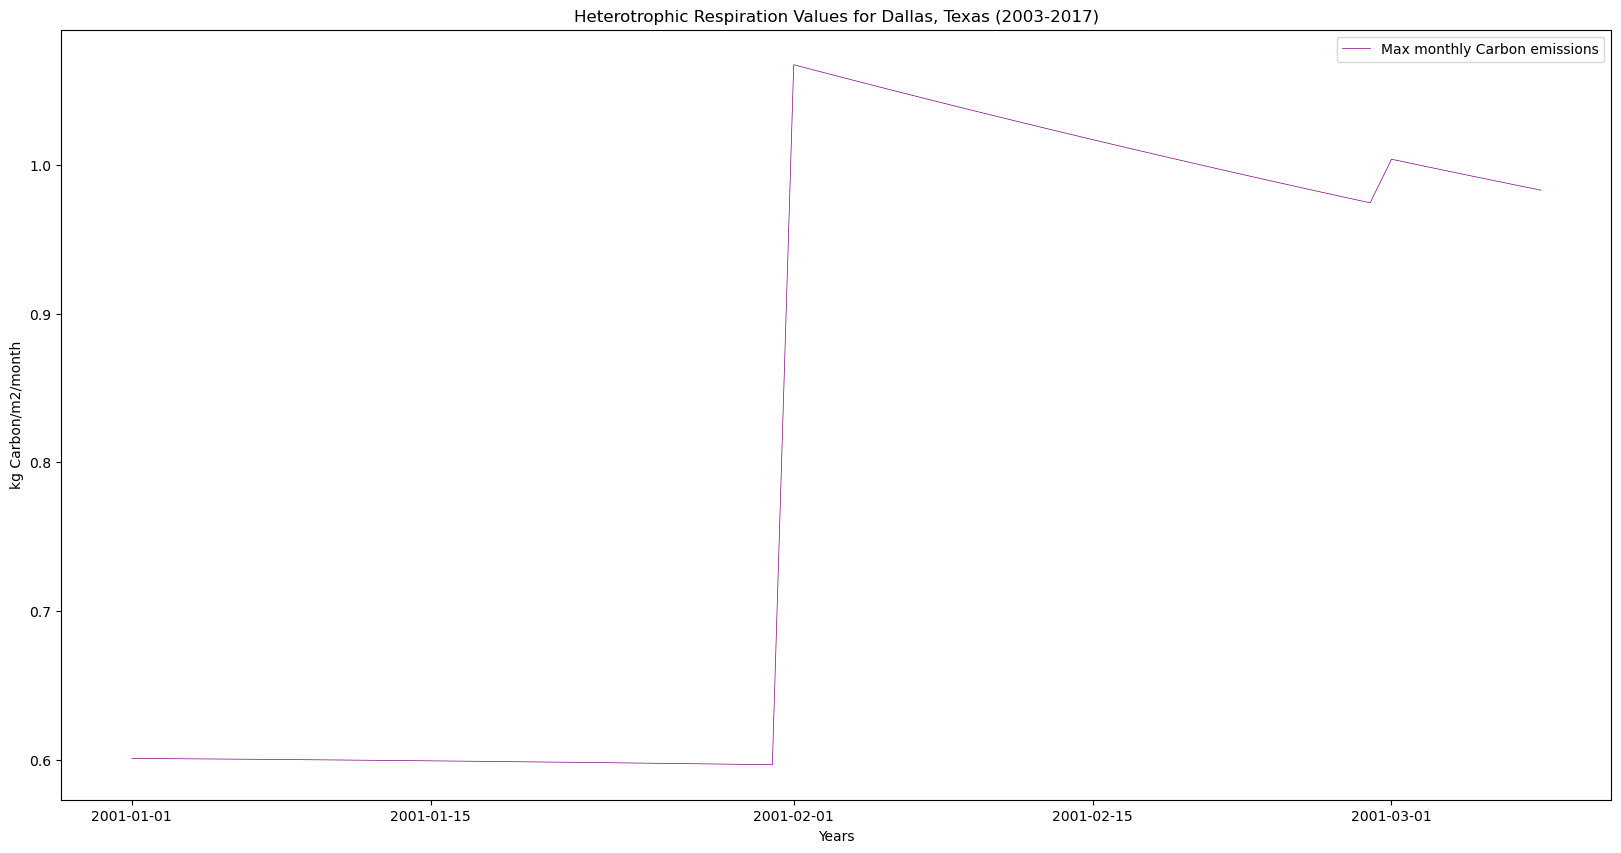

In [71]:
fig = plt.figure(figsize=(20, 10)) #determine the width and height of the plot using the 'matplotlib' library

plt.plot(
    df["date"],
    df["max"],
    color="purple",
    linestyle="-",
    linewidth=0.5,
    label="Max monthly Carbon emissions",
)

plt.legend()
plt.xlabel("Years")
plt.ylabel("kg Carbon/m2/month")
plt.title("Heterotrophic Respiration Values for Dallas, Texas (2003-2017)")

In [73]:
# Now let's examine the Rh level for the 3rd item in the collection for Dallas, Texas area
# Keep in mind that a list starts from 0, 1, 2,... therefore items[2] is referring to the third item in the list/collection
print(items[2]["properties"]["datetime"]) #print the start Date Time of the third granule in the collection!

2001-03-06T00:00:00+00:00


In [74]:
# Fetch the third granule in the collection and set the color scheme and rescale values. 
october_tile = requests.get(
    f"{RASTER_API_URL}/stac/tilejson.json?collection={items[2]['collection']}&item={items[2]['id']}"
    f"&assets={asset_name}"
    f"&color_formula=gamma+r+1.05&colormap_name={color_map}"
    f"&rescale={rescale_values['min']},{rescale_values['max']}",
).json()
october_tile

{'tilejson': '2.2.0',
 'version': '1.0.0',
 'scheme': 'xyz',
 'tiles': ['https://dev.ghg.center/ghgcenter/api/raster/stac/tiles/WebMercatorQuad/{z}/{x}/{y}@1x?collection=micasa-carbonflux-daygrid-v1&item=micasa-carbonflux-daygrid-v1-20010306&assets=rh&color_formula=gamma+r+1.05&colormap_name=purd&rescale=-0.28565365076065063%2C5.658170223236084'],
 'minzoom': 0,
 'maxzoom': 24,
 'bounds': [-180.0, -90.0, 179.99999999999994, 90.0],
 'center': [-2.842170943040401e-14, 0.0, 0]}

In [75]:
# Map the Rh level for the Dallas, Texas area for the October, 2017 timeframe
aoi_map_bbox = Map(
    tiles="OpenStreetMap",
    location=[
        32.8, # latitude
        -96.79, # longitude
    ],
    zoom_start=9,
)

map_layer = TileLayer(
    tiles=october_tile["tiles"][0],
    attr="GHG", opacity = 0.7, name="October 2017 RH Level", overlay= True, legendEnabled = True
)

map_layer.add_to(aoi_map_bbox)

# Display data marker (title) on the map
folium.Marker((40, 5.9), tooltip="both").add_to(aoi_map_bbox)
folium.LayerControl(collapsed=False).add_to(aoi_map_bbox)

# Add a legend
colormap = branca.colormap.linear.PuRd_09.scale(0, 0.3) # minimum value = 0, maximum value = 0.3 (kg Carbon/m2/month)
colormap = colormap.to_step(index=[0, 0.07, 0.15, 0.22, 0.3])
colormap.caption = 'Rh Values (kg Carbon/m2/month)'

colormap.add_to(aoi_map_bbox)

aoi_map_bbox

## Summary

In this notebook we have successfully completed the following steps for the STAC collection for CASA GFED Land-Atmosphere Carbon Flux data:
1.	Install and import the necessary libraries 
2.	Fetch the collection from STAC collections using the appropriate endpoints
3.	Count the number of existing granules within the collection
4.	Map and compare the Heterotrophic Respiration (Rh) levels over the Dallas, Texas area for two distinctive years
5.	Create a table that displays the minimum, maximum, and sum of the Rh values for a specified region
6.	Generate a time-series graph of the Rh values for a specified region

If you have any questions regarding this user notebook, please contact us using the [feedback form](https://docs.google.com/forms/d/e/1FAIpQLSeVWCrnca08Gt_qoWYjTo6gnj1BEGL4NCUC9VEiQnXA02gzVQ/viewform). 